[View in Colaboratory](https://colab.research.google.com/github/webserg/pythonML/blob/master/colab/plankton.ipynb)

https://www.kaggle.com/c/datasciencebowl/data
http://benanne.github.io/2015/03/17/plankton.html


In [1]:
!pip install kaggle

  Running setup.py bdist_wheel for kaggle ... - \ done
  Stored in directory: /content/.cache/pip/wheels/d6/3c/92/375decc0cf0a65b281db3cca9b8e21dc27b8ebc4d1ce29afca
Successfully built kaggle


In [2]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [0]:
!kaggle competitions list

In [4]:
!pwd

/content


In [3]:
!ls -l

total 4
drwxr-xr-x 1 root root 4096 May 21 06:19 datalab


In [3]:
!kaggle competitions download -c datasciencebowl -p ./plankton

sampleSubmission.csv.zip: Downloaded 886KB of 886KB to ./plankton
train.zip: Downloaded 76MB of 76MB to ./plankton
test.zip: Downloaded 347MB of 347MB to ./plankton
plankton_identification.pdf: Downloaded 2MB of 2MB to ./plankton


In [0]:
%mkdir /content/plankton/validation/

In [5]:
%ls -l

total 0


In [5]:
import zipfile
import os
data_dir = "/content/plankton"
path_to_data = "/content/plankton/train.zip"
path_to_data

'/content/plankton/train.zip'

In [0]:
if os.path.exists(data_dir) == False:
    os.makedirs(data_dir)

In [0]:
zip_ref = zipfile.ZipFile(path_to_data, 'r')
zip_ref.extractall(data_dir)
zip_ref.close()

In [7]:
path_to_test = "/content/plankton/test.zip"
path_to_test

'/content/plankton/test.zip'

In [0]:
 os.makedirs(data_dir + "/test")

In [0]:
zip_ref = zipfile.ZipFile(path_to_test, 'r')
zip_ref.extractall(data_dir + "/test")
zip_ref.close()

In [0]:
validation_dir = os.path.join(data_dir, 'validation')
if os.path.exists(validation_dir) == False:
    os.mkdir(validation_dir)

In [0]:
import shutil
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [0]:
validation_dir = os.path.join(data_dir, 'validation')

dir_info = [x for x in os.walk(train_dir)]
for dir in dir_info[1:]:
    #print(len(dir[2]))
    validation_number = int(round(len(dir[2])/20))
    #print(validation_number)
    #print(dir[2])
    #print(dir[2][:validation_number])
    dir_name = os.path.split(dir[0])[1]
    #print(dir_name)
    validation_dir_current = os.path.join(validation_dir, dir_name)
    if os.path.exists(validation_dir_current) == False:
        os.mkdir(validation_dir_current)
    for fname in dir[2][:validation_number]:
        src = os.path.join(train_dir, dir_name, fname)
        dst = os.path.join(validation_dir_current, fname)
        #print(src)
        #print(dst)
        shutil.move(src, dst)


In [0]:
if os.path.exists(validation_dir) == False:
    print("false")

In [12]:
print('total training categories:', len(os.listdir(train_dir)))
cpt = sum([len(files) for r, d, files in os.walk(train_dir)])
print('all train images: ',cpt )

total training categories: 121
all train images:  28813


In [13]:
print('total validation categories:', len(os.listdir(validation_dir)))
cpt = sum([len(files) for r, d, files in os.walk(validation_dir)])
print('all validation images: ',cpt )

total validation categories: 121
all validation images:  1523


In [0]:
size_of_image = (300, 300)

In [63]:
from keras.preprocessing.image import ImageDataGenerator
#train_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    )
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=size_of_image,
batch_size=32,
color_mode='grayscale',
class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
validation_dir,
target_size=size_of_image,
batch_size=32,
color_mode='grayscale',
class_mode='categorical')

Found 28813 images belonging to 121 classes.
Found 1523 images belonging to 121 classes.


32
<class 'tuple'>
<class 'numpy.ndarray'>
(300, 300, 1)


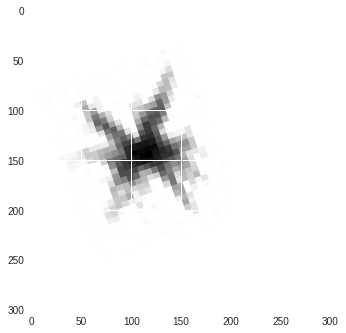

In [64]:
from matplotlib import pyplot
print(train_generator.batch_size)
print(type(train_generator.next()))
(q,w)=train_generator.next()
print(type(q[0]))
print(q[2].shape)
pyplot.imshow(q[4].reshape(size_of_image),  cmap=pyplot.get_cmap('gray'))
pyplot.show()

In [65]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(size_of_image[0], size_of_image[1], 1)))
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3),strides=2))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3),strides=2))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3),strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((3, 3),strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(121, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 298, 298, 32)      320       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 296, 296, 16)      4624      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 147, 147, 16)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 145, 145, 64)      9280      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 143, 143, 32)      18464     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 71, 71, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 69, 69, 128)       36992     
__________

In [0]:
from keras import optimizers
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.Adam(lr=0.001),
metrics=['acc'])

In [67]:
history = model.fit_generator(
train_generator,
epochs=20,
validation_data=validation_generator)
model.save('/content/plankton/plankton_1.h5')

Epoch 1/20
901/901 [==============================] - 355s 394ms/step - loss: 4.2169 - acc: 0.0612 - val_loss: 4.1711 - val_acc: 0.0650
Epoch 2/20
 74/901 [=>............................] - ETA: 5:12 - loss: 4.1831 - acc: 0.0633

901/901 [==============================] - 347s 385ms/step - loss: 4.1899 - acc: 0.0650 - val_loss: 4.1654 - val_acc: 0.0637
Epoch 3/20
151/901 [====>.........................] - ETA: 4:43 - loss: 4.1596 - acc: 0.0613

901/901 [==============================] - 347s 385ms/step - loss: 4.1791 - acc: 0.0629 - val_loss: 4.1639 - val_acc: 0.0637
Epoch 4/20
180/901 [====>.........................] - ETA: 4:32 - loss: 4.1641 - acc: 0.0705

901/901 [==============================] - 347s 385ms/step - loss: 4.1757 - acc: 0.0645 - val_loss: 4.1663 - val_acc: 0.0650
Epoch 5/20
191/901 [=====>........................] - ETA: 4:28 - loss: 4.1747 - acc: 0.0640

901/901 [==============================] - 346s 384ms/step - loss: 4.1746 - acc: 0.0648 - val_loss: 4.1648 - val_acc: 0.0650
Epoch 6/20
195/901 [=====>........................] - ETA: 4:26 - loss: 4.1726 - acc: 0.0681

901/901 [==============================] - 346s 384ms/step - loss: 4.1723 - acc: 0.0639 - val_loss: 4.1634 - val_acc: 0.0637
Epoch 7/20
196/901 [=====>........................] - ETA: 4:26 - loss: 4.1649 - acc: 0.0657

901/901 [==============================] - 347s 385ms/step - loss: 4.1689 - acc: 0.0637 - val_loss: 4.1643 - val_acc: 0.0637
Epoch 8/20
197/901 [=====>........................] - ETA: 4:25 - loss: 4.1489 - acc: 0.0723

901/901 [==============================] - 346s 385ms/step - loss: 4.1690 - acc: 0.0662 - val_loss: 4.1621 - val_acc: 0.0637
Epoch 9/20
197/901 [=====>........................] - ETA: 4:25 - loss: 4.1517 - acc: 0.0684

901/901 [==============================] - 347s 385ms/step - loss: 4.1667 - acc: 0.0653 - val_loss: 4.1624 - val_acc: 0.0650
Epoch 10/20
196/901 [=====>........................] - ETA: 4:26 - loss: 4.1706 - acc: 0.0646

901/901 [==============================] - 347s 385ms/step - loss: 4.1676 - acc: 0.0644 - val_loss: 4.1618 - val_acc: 0.0637
Epoch 11/20
196/901 [=====>........................] - ETA: 4:25 - loss: 4.1722 - acc: 0.0560

901/901 [==============================] - 347s 385ms/step - loss: 4.1679 - acc: 0.0609 - val_loss: 4.1619 - val_acc: 0.0650
Epoch 12/20
196/901 [=====>........................] - ETA: 4:26 - loss: 4.1788 - acc: 0.0674

901/901 [==============================] - 347s 385ms/step - loss: 4.1668 - acc: 0.0657 - val_loss: 4.1619 - val_acc: 0.0650
Epoch 13/20
196/901 [=====>........................] - ETA: 4:26 - loss: 4.1630 - acc: 0.0623

901/901 [==============================] - 347s 385ms/step - loss: 4.1669 - acc: 0.0627 - val_loss: 4.1620 - val_acc: 0.0637
Epoch 14/20
196/901 [=====>........................] - ETA: 4:25 - loss: 4.1482 - acc: 0.0628

901/901 [==============================] - 347s 385ms/step - loss: 4.1665 - acc: 0.0657 - val_loss: 4.1616 - val_acc: 0.0637
Epoch 15/20
196/901 [=====>........................] - ETA: 4:26 - loss: 4.1767 - acc: 0.0603

901/901 [==============================] - 347s 385ms/step - loss: 4.1657 - acc: 0.0652 - val_loss: 4.1617 - val_acc: 0.0637
Epoch 16/20
196/901 [=====>........................] - ETA: 4:26 - loss: 4.1598 - acc: 0.0654

901/901 [==============================] - 347s 385ms/step - loss: 4.1656 - acc: 0.0646 - val_loss: 4.1614 - val_acc: 0.0637
Epoch 17/20
196/901 [=====>........................] - ETA: 4:25 - loss: 4.1591 - acc: 0.0623

901/901 [==============================] - 347s 385ms/step - loss: 4.1648 - acc: 0.0626 - val_loss: 4.1617 - val_acc: 0.0637
Epoch 18/20
196/901 [=====>........................] - ETA: 4:26 - loss: 4.1781 - acc: 0.0649

901/901 [==============================] - 347s 385ms/step - loss: 4.1655 - acc: 0.0651 - val_loss: 4.1617 - val_acc: 0.0650
Epoch 19/20
196/901 [=====>........................] - ETA: 4:26 - loss: 4.1694 - acc: 0.0643

901/901 [==============================] - 347s 385ms/step - loss: 4.1656 - acc: 0.0653 - val_loss: 4.1614 - val_acc: 0.0650
Epoch 20/20
196/901 [=====>........................] - ETA: 4:26 - loss: 4.1935 - acc: 0.0603

901/901 [==============================] - 347s 385ms/step - loss: 4.1655 - acc: 0.0643 - val_loss: 4.1614 - val_acc: 0.0650


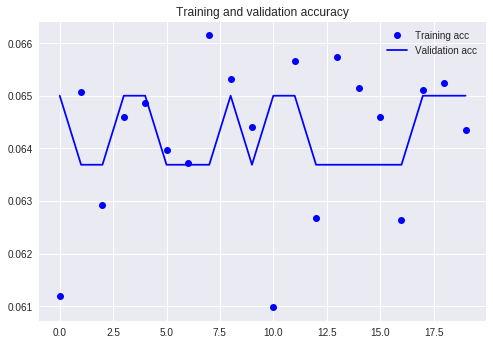

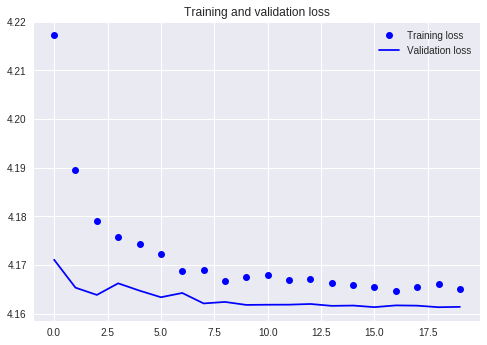

In [68]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


In [69]:
print(test_dir)
from keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=size_of_image,
        color_mode='grayscale',
        classes=None,
        class_mode=None)


/content/plankton/test
Found 130400 images belonging to 1 classes.


In [0]:
from keras.models import load_model
saved_model = load_model('plankton_1.h5')

In [0]:
import numpy as np
res = model.predict_generator(test_generator)


In [26]:
len(test_generator.filenames)

130400

In [27]:
res[100][5]

0.0126115

In [71]:
import pandas as pd
image_index = [x.replace("test/","") for x in test_generator.filenames]
df = pd.DataFrame(data=res, columns=[*train_generator.class_indices],index=image_index)
df.head()

,acantharia_protist,acantharia_protist_big_center,acantharia_protist_halo,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts,artifacts_edge,...,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid,tunicate_doliolid_nurse,tunicate_partial,tunicate_salp,tunicate_salp_chains,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
1.jpg,0.030023,0.00039,0.002175,0.001533,0.000493,0.022557,0.018688,0.008578,0.012234,0.005953,...,0.021413,0.000871,0.014855,0.012931,0.011088,0.008216,0.002267,0.010644,0.005649,0.014549
10.jpg,0.030023,0.00039,0.002175,0.001533,0.000493,0.022557,0.018688,0.008578,0.012234,0.005953,...,0.021413,0.000871,0.014855,0.012931,0.011088,0.008216,0.002267,0.010644,0.005649,0.014549
100.jpg,0.030023,0.00039,0.002175,0.001533,0.000493,0.022557,0.018688,0.008578,0.012234,0.005953,...,0.021413,0.000871,0.014855,0.012931,0.011088,0.008216,0.002267,0.010644,0.005649,0.014549
1000.jpg,0.030023,0.00039,0.002175,0.001533,0.000493,0.022557,0.018688,0.008578,0.012234,0.005953,...,0.021413,0.000871,0.014855,0.012931,0.011088,0.008216,0.002267,0.010644,0.005649,0.014549
10000.jpg,0.030023,0.00039,0.002175,0.001533,0.000493,0.022557,0.018688,0.008578,0.012234,0.005953,...,0.021413,0.000871,0.014855,0.012931,0.011088,0.008216,0.002267,0.010644,0.005649,0.014549


In [72]:
df.index.name = 'image'
df.head()

,acantharia_protist,acantharia_protist_big_center,acantharia_protist_halo,amphipods,appendicularian_fritillaridae,appendicularian_s_shape,appendicularian_slight_curve,appendicularian_straight,artifacts,artifacts_edge,...,trichodesmium_tuft,trochophore_larvae,tunicate_doliolid,tunicate_doliolid_nurse,tunicate_partial,tunicate_salp,tunicate_salp_chains,unknown_blobs_and_smudges,unknown_sticks,unknown_unclassified
image,,,,,,,,,,,,,,,,,,,,,
1.jpg,0.030023,0.00039,0.002175,0.001533,0.000493,0.022557,0.018688,0.008578,0.012234,0.005953,...,0.021413,0.000871,0.014855,0.012931,0.011088,0.008216,0.002267,0.010644,0.005649,0.014549
10.jpg,0.030023,0.00039,0.002175,0.001533,0.000493,0.022557,0.018688,0.008578,0.012234,0.005953,...,0.021413,0.000871,0.014855,0.012931,0.011088,0.008216,0.002267,0.010644,0.005649,0.014549
100.jpg,0.030023,0.00039,0.002175,0.001533,0.000493,0.022557,0.018688,0.008578,0.012234,0.005953,...,0.021413,0.000871,0.014855,0.012931,0.011088,0.008216,0.002267,0.010644,0.005649,0.014549
1000.jpg,0.030023,0.00039,0.002175,0.001533,0.000493,0.022557,0.018688,0.008578,0.012234,0.005953,...,0.021413,0.000871,0.014855,0.012931,0.011088,0.008216,0.002267,0.010644,0.005649,0.014549
10000.jpg,0.030023,0.00039,0.002175,0.001533,0.000493,0.022557,0.018688,0.008578,0.012234,0.005953,...,0.021413,0.000871,0.014855,0.012931,0.011088,0.008216,0.002267,0.010644,0.005649,0.014549


In [73]:
df.to_csv("/content/plankton/result.csv", encoding='utf-8',index=image_index)
result2 = pd.read_csv('/content/plankton/result.csv')
result2.columns

Index(['image', 'acantharia_protist', 'acantharia_protist_big_center',
       'acantharia_protist_halo', 'amphipods', 'appendicularian_fritillaridae',
       'appendicularian_s_shape', 'appendicularian_slight_curve',
       'appendicularian_straight', 'artifacts',
       ...
       'trichodesmium_tuft', 'trochophore_larvae', 'tunicate_doliolid',
       'tunicate_doliolid_nurse', 'tunicate_partial', 'tunicate_salp',
       'tunicate_salp_chains', 'unknown_blobs_and_smudges', 'unknown_sticks',
       'unknown_unclassified'],
      dtype='object', length=122)

In [74]:
!kaggle competitions submit -c datasciencebowl -f /content/plankton/result.csv -m "Adam(lr=0.001) 20 epoch gray scale"

Successfully submitted to National Data Science Bowl